# Overview

This repo consists of a walkthrough for creating a dataset of protein sequences in a similar fashion as was done by [Zhou & Troyanskaya, 2014](https://arxiv.org/pdf/1403.1347.pdf). The authors of that paper used a dataset constructed as outlined below to train convolutional generative stochastic networks for protein secondary structure prediction (PSSP). The modest goal is to introduce individuals with experience in machine/deep learning to the basics of structural bioinformatics by constructing a dataset for PSSP as well as other, related tasks.

### Packages Used

- Python 3
- Pandas
- BioPython
- TensorFlow

## Proteins - primary sequence and secondary structure

Proteins are one of the most important classes of macromolecules in biology. They are composed of linear chains of 20 (sometimes 22) proteinogenic amino acids. Each amino acid can be represented by a single letter, allowing us to express proteins as a string. For example, the sequence for hemoglobin is:
>VLSPADKTNVKAAWGKVGAHAGEYGAEALERMFLSFPTTKTYFPHFDLSHGSAQVKGHGKKVADALTNAVAHVDDMPNALSALSDLHAHKLRVDPVNFKLLSHCLLVTLAAHLPAEFTPAVHASLDKFLASVSTVLTSKYR

When found in the appropriate biological context, proteins assume - through a complex interplay of physicochemical forces - a 3-dimensional conformation, referred to as the protein's *tertiary* or *native* structure. This native state determines how a particular protein behaves; that is, form determines function. Accurately predicting tertiary structure is therefore the first and most fundamental step for understanding the function of discovered proteins as well as for designing new proteins with entirely novel functions.

During the folding process, regions along the protein backbone assume local conformations called secondary structures. These secondary structures are characterized by the patterns of hydrogen bonds formed between amino acids in a particular region. One common way of categorizing such structures is given by the dictionary of protein secondary structires [DSSP](https://swift.cmbi.umcn.nl/gv/dssp/). Since nearly all secondary structures are localized to a particular region of the backbone, they can also be written as a string of letters, where each letter corresponds to a particular secondary structure. Hemoglobin, aligned with its secondary structures, is as follows:

>       VLSPADKTNV KAAWGKVGAH AGEYGAEALE RMFLSFPTTK TYFPHFDLSH GSAQVKGHGK KVADALTNAV AHVDDMPNAL SALSDLHAHK LRVDPVNFKL LSHCLLVTLA AHLPAEFTPA VHASLDKFLA SVSTVLTSKY R
>          HHHHHHH HHHHHHHGGG HHHHHHHHHH HHHHH GGGG GG TTS  ST T HHHHHHHH HHHHHHHHHH HTTTSHHHHT HHHHHHHHHT T   THHHHH HHHHHHHHHH HH TTT  HH HHHHHHHHHH HHHHHHHTT
           

## Combining Cull PDB and DSSP

The protein data bank [(PDB)](https://www.rcsb.org/) is an online repository of hundreds of thousands of proteins whose 3d structure has been resolved experimentally. We will use the web server CullPDB: PISCES to extract a diverse set of proteins from the PDB, and the use DSSP to find their secondary structures.

### Cull PDB: PISCES

Proteins from the PDB can be queried based on criteria such as resolution, sequence identity, etc. It's possible (as of 20/03/2018) to download different lists [here](http://dunbrack.fccc.edu/Guoli/pisces_download.php).

### DSSP files

The PISCES lists provide PDB ID's, but they do not have the secondary structure information. To get that, we need to download the DSSP information from the PDB. This can be done directly [here](http://swift.cmbi.ru.nl/gv/dssp/).

By syncing the database locally, the individual \*.dssp files can be parsed by the script [parse_dssp.py](./parse_dssp.py).

### Note on CPDB chains and DSSP ids
The PISCES server checks each CHAIN of a PDB entry individually. As such, the cpdb IDs may contain all or only some of the chains of a particular PDB entry. On the other hand, the DSSP outputs a single file / entry per PDB ID, which will include all of the chains for that entry.

The `parse_dssp.py` script will split dssp files into their constituent chains, appending the chain id to the end of the dssp_id, and creating records for each chain. Some edges cases where the parser incorrectly identifies the chain id exist, but those are skipped.

### Note on CPDB sequences with the character 'b', and 'j', and 'o', and 'u', and 'z'
According to the description of DSSP, lowercase characters indicate a SS-bridge Cysteine. These come in pairs; only some of them show up as bad characters, because when capitalized, some are valid amino acid codes.

The strategy for these is thus to replace them with 'C' for cysteine.

### Next Steps
The rest of this notebook will assume that a list downloaded from PISCES as well as some number of .csv files containing the parsed DSSP data exist in a `data/dssp` folder.

## Joining the Data

We want to do a join on the PDB id field of the PISCES and DSSP datasets. Since these are both in either tab-separated or csv format, Pandas is an ideal candidate for doing this.

We want to concatenate the two datasets, joining on the two id's. Since the cpdb data is a subset of the dssp data, we join on the cpdb id field. See [merge_data.py](./merge_data.py) for more details.

In the code below, we drop sequences below 26 residues in length and save the results of the merge to the file `cpdb2_records.csv`.

In [1]:
import pandas as pd
from pathlib import Path
datadir = str(Path(Path.home(), "data", "dssp"))

In [2]:
# from merge_data import merge
# merged = merge()

# merged = merged[merged.seq.str.len() > 25]
# merged.to_csv(datadir+"/cpdb2_records.csv")

## Generate the Position-Specific Similary Matrices
Similar to CPDB, we can calculate position-specific profile similarity scores using PSI-BLAST. The process is as follows:

### CPDB2 to FASTA format
In order to make calculating the PSSMs amenable to the CPDB2 dataset, we save the `dssp_id` and `seq` fields in FASTA file format.
Some of these records contain leftover `!` gap symbols, so these are replaced with `*` to indicate a gap of indeterminate length
in the sequence, as described [here](https://blast.ncbi.nlm.nih.gov/Blast.cgi?CMD=Web&PAGE_TYPE=BlastDocs&DOC_TYPE=BlastHelp)

See the [csv_to_fasta.py](./csv_to_fasta.py) file.

### Download and preprocess UniRef90
Download the [UniRef90](http://www.uniprot.org/downloads) dataset, and filter using [pfilt](http://bioinf.cs.ucl.ac.uk/psipred/) to remove low information content and coiled-coil regions.

#### pfilt
See the [README](http://bioinfadmin.cs.ucl.ac.uk/downloads/pfilt/).


### Download BLAST+ and create a local database
Create a BLAST database out of the filtered sequences in FASTA format using the blast command line tool, described [here](https://www.ncbi.nlm.nih.gov/books/NBK279688/). The BLAST+ software is available [here](https://blast.ncbi.nlm.nih.gov/Blast.cgi?CMD=Web&PAGE_TYPE=BlastDocs&DOC_TYPE=Download).

### Run PSIBLAST to get the scores
Run PSI-BLAST on the CullPDB dataset downloaded via PISCES against the BLAST database just created, 
with an inclusion threshold of 0.001 for 3 iterations.

Transform the profile scores into the 
range [0, 1) via logistic sigmoid
```bash
psiblast -db uniref90_filt_db -query example.fasta -out output.psiblast -evalue 0.001 -num_threads 4 -num_iterations 3 -out_pssm output.pssm -out_ascii_pssm asci_test.pssm -save_pssm_after_last_round
```

**Note** that PSIBLAST will only save the PSSM for a SINGLE protein at a time. Each new profile score overwrites the previous, so the sequences need to be run independently.

# Physicochemical properties

Along with position-specific similarity matrix scores, we also use a number of physicochemical properties to describe amino acids:

In [3]:
aa_feats = pd.read_csv("aa_feats.csv", index_col=0)
aa_feats = aa_feats.drop(labels=["X"], axis=0)
aa_feats

,hydrophobicity,polar,hydropathy intensity,hydrophilicity,pH_l,vdW_vol,pK1,pK2,steric,polarizability
A,0.0,0.0,1.8,3.0,6.01,67.0,2.35,9.87,1.28,0.05
C,1.0,-1.0,2.5,-1.0,5.05,86.0,1.92,10.70,1.77,0.13
D,2.0,1.0,-3.5,3.0,2.85,91.0,1.99,9.90,1.60,0.11
E,2.0,1.0,-3.5,3.0,3.15,109.0,2.10,9.47,0.00,0.15
F,1.0,-1.0,2.8,-2.5,5.49,135.0,2.20,9.31,2.94,0.29
G,0.0,0.0,-0.4,0.0,6.06,48.0,2.35,9.78,0.00,0.00
H,-1.0,1.0,-3.2,-0.5,7.60,118.0,1.80,9.33,2.99,0.23
I,1.0,-1.0,4.5,-1.8,6.05,124.0,2.32,9.76,4.19,0.19
K,2.0,1.0,-3.9,3.0,9.60,135.0,2.16,9.06,1.89,0.22
L,1.0,-1.0,3.8,-1.8,6.01,124.0,2.33,9.74,2.59,0.19


### PCA on features
There is some redundancy in these features, which we can see by examining the correlation coefficients.

In [4]:
aa_feats.corr()

,hydrophobicity,polar,hydropathy intensity,hydrophilicity,pH_l,vdW_vol,pK1,pK2,steric,polarizability
hydrophobicity,1.000000,-0.071685,0.116361,0.256511,0.098194,0.304599,0.018649,0.237080,-0.023572,0.265580
polar,-0.071685,1.000000,-0.856103,0.793689,0.175193,-0.167100,-0.515392,-0.352830,-0.514872,-0.220739
hydropathy intensity,0.116361,-0.856103,1.000000,-0.579074,-0.185182,-0.116596,0.459863,0.544784,0.452738,-0.141111
hydrophilicity,0.256511,0.793689,-0.579074,1.000000,0.144248,-0.319574,-0.385994,-0.071089,-0.613583,-0.391803
pH_l,0.098194,0.175193,-0.185182,0.144248,1.000000,0.364222,-0.214373,-0.301306,0.253380,0.286892
vdW_vol,0.304599,-0.167100,-0.116596,-0.319574,0.364222,1.000000,-0.009948,-0.400525,0.567074,0.939633
pK1,0.018649,-0.515392,0.459863,-0.385994,-0.214373,-0.009948,1.000000,-0.057576,0.081364,0.057177
pK2,0.237080,-0.352830,0.544784,-0.071089,-0.301306,-0.400525,-0.057576,1.000000,-0.005957,-0.450413
steric,-0.023572,-0.514872,0.452738,-0.613583,0.253380,0.567074,0.081364,-0.005957,1.000000,0.484432
polarizability,0.265580,-0.220739,-0.141111,-0.391803,0.286892,0.939633,0.057177,-0.450413,0.484432,1.000000


In [5]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [6]:
pca = PCA(n_components=3)
pca.fit(aa_feats.values)
X = pca.transform(aa_feats.values)

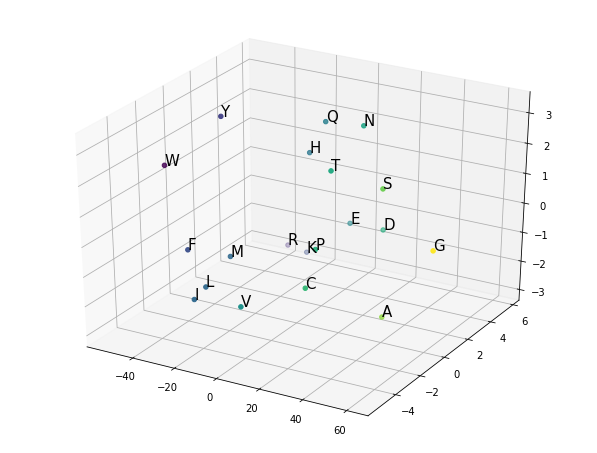

In [7]:
fig = plt.figure(1, figsize=(8, 6))
plt.clf()
ax = Axes3D(fig)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=X[:, 0], cmap=plt.cm.viridis)
for i, txt in enumerate(list(aa_feats.index)):
    ax.text(X[i, 0], X[i, 1], X[i, 2], "%s" % (txt), size=15, color="k")
plt.show()

We remove any features that has an absolute correlation coefficient with any other feature greater than 0.6, leaving us with:

In [8]:
low_corr_feats = ["hydrophobicity", "hydropathy intensity", "pH_l", "pK1", "pK2", "steric", "polarizability"]
aa_feats_2 = aa_feats[low_corr_feats]

In [9]:
aa_feats_2

,hydrophobicity,hydropathy intensity,pH_l,pK1,pK2,steric,polarizability
A,0.0,1.8,6.01,2.35,9.87,1.28,0.05
C,1.0,2.5,5.05,1.92,10.70,1.77,0.13
D,2.0,-3.5,2.85,1.99,9.90,1.60,0.11
E,2.0,-3.5,3.15,2.10,9.47,0.00,0.15
F,1.0,2.8,5.49,2.20,9.31,2.94,0.29
G,0.0,-0.4,6.06,2.35,9.78,0.00,0.00
H,-1.0,-3.2,7.60,1.80,9.33,2.99,0.23
I,1.0,4.5,6.05,2.32,9.76,4.19,0.19
K,2.0,-3.9,9.60,2.16,9.06,1.89,0.22
L,1.0,3.8,6.01,2.33,9.74,2.59,0.19


To make the features more amenable to training, we normalize the features except for hydrophobicity.

In [10]:
for feat in ["hydropathy intensity", "pH_l", "pK1", "pK2", "steric", "polarizability"]:
    aa_feats_2[feat] = (aa_feats_2[feat] - aa_feats_2[feat].mean()) / aa_feats_2[feat].std()
aa_feats_2

/home/dillon/.conda/envs/tf1_7/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,hydrophobicity,hydropathy intensity,pH_l,pK1,pK2,steric,polarizability
A,0.0,0.707641,-0.009696,1.058258,0.691227,-0.838612,-1.144703
C,1.0,0.940199,-0.557225,-1.251645,2.318798,-0.390254,-0.381568
D,2.0,-1.053156,-1.811980,-0.875614,0.750055,-0.545807,-0.572351
E,2.0,-1.053156,-1.640877,-0.284709,-0.093144,-2.009831,-0.190784
F,1.0,1.039867,-0.306274,0.252478,-0.406893,0.680314,1.144703
G,0.0,-0.023256,0.018821,1.058258,0.514744,-2.009831,-1.621663
H,-1.0,-0.953488,0.897150,-1.896269,-0.367674,0.726065,0.572351
I,1.0,1.604651,0.013118,0.897102,0.475525,1.824083,0.190784
K,2.0,-1.186046,2.037835,0.037603,-0.897125,-0.280452,0.476960
L,1.0,1.372093,-0.009696,0.950821,0.436307,0.360059,0.190784


In [11]:
aa_feats_2.mean(axis=0)

hydrophobicity          1.500000e-01
hydropathy intensity   -5.551115e-18
pH_l                    3.733125e-16
pK1                     2.375877e-15
pK2                    -3.314016e-15
steric                  1.110223e-16
polarizability         -1.110223e-16
dtype: float64

In [12]:
aa_feats_2.std(axis=0)

hydrophobicity          1.531253
hydropathy intensity    1.000000
pH_l                    1.000000
pK1                     1.000000
pK2                     1.000000
steric                  1.000000
polarizability          1.000000
dtype: float64

In [13]:
# re-add the "unknown" amino acid character, X
aa_feats_2.loc["X"] = [0 for _ in range(aa_feats_2.shape[1])]

/home/dillon/.conda/envs/tf1_7/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [14]:
aa_feats_2

,hydrophobicity,hydropathy intensity,pH_l,pK1,pK2,steric,polarizability
A,0.0,0.707641,-0.009696,1.058258,0.691227,-0.838612,-1.144703
C,1.0,0.940199,-0.557225,-1.251645,2.318798,-0.390254,-0.381568
D,2.0,-1.053156,-1.811980,-0.875614,0.750055,-0.545807,-0.572351
E,2.0,-1.053156,-1.640877,-0.284709,-0.093144,-2.009831,-0.190784
F,1.0,1.039867,-0.306274,0.252478,-0.406893,0.680314,1.144703
G,0.0,-0.023256,0.018821,1.058258,0.514744,-2.009831,-1.621663
H,-1.0,-0.953488,0.897150,-1.896269,-0.367674,0.726065,0.572351
I,1.0,1.604651,0.013118,0.897102,0.475525,1.824083,0.190784
K,2.0,-1.186046,2.037835,0.037603,-0.897125,-0.280452,0.476960
L,1.0,1.372093,-0.009696,0.950821,0.436307,0.360059,0.190784


In [15]:
aa_feats_2.to_csv("aa_feats_final.csv")